[View in Colaboratory](https://colab.research.google.com/github/IWichakam/smart-city/blob/master/ARIMA.ipynb)

 
# Time Series Forecast Case Study with Python: Annual Water Usage in Baltimore

https://machinelearningmastery.com/time-series-forecast-study-python-annual-water-usage-baltimore/

![alt text](https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2017/02/Time-Series-Forecast-Study-with-Python-Annual-Water-Usage-in-Baltimore.jpg)

## Environment

In [122]:
# scipy
import scipy
print('scipy: %s' % scipy.__version__)
# numpy
import numpy
print('numpy: %s' % numpy.__version__)
# matplotlib
import matplotlib
print('matplotlib: %s' % matplotlib.__version__)
# pandas
import pandas
print('pandas: %s' % pandas.__version__)
# scikit-learn
import sklearn
print('sklearn: %s' % sklearn.__version__)
# statsmodels
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)

scipy: 0.19.1
numpy: 1.14.5
matplotlib: 2.1.2
pandas: 0.22.0
sklearn: 0.19.2
statsmodels: 0.8.0


## Problem Description

The problem is to predict annual water usage.

The dataset provides the annual water usage in Baltimore from 1885 to 1963, or 79 years of data.

The values are in the units of liters per capita per day, and there are 79 observations.

The dataset is credited to Hipel and McLeod, 1994.

You can learn more about this dataset and download it directly from DataMarket: https://datamarket.com/data/set/22sl/baltmore-city-annual-water-use-liters-per-capita-per-day-1885-1968#!ds=22sl&display=line

In [123]:
!wget https://github.com/IWichakam/smart-city/raw/master/baltmore-city-annual-water-use-l.csv
!ls


Redirecting output to ‘wget-log.2’.
baltmore-city-annual-water-use-l.csv	sample_data	wget-log.1
baltmore-city-annual-water-use-l.csv.1	stationary.csv	wget-log.2
baltmore-city-annual-water-use-l.csv.2	validation.csv
dataset.csv				wget-log


## Test Harness

### Validation Dataset

The dataset is not current. This means that we cannot easily collect updated data to validate the model.

Therefore, we will pretend that it is 1953 and withhold the last 10 years of data from analysis and model selection.

This final decade of data will be used to validate the final model.

The code below will load the dataset as a Pandas Series and split into two, one for model development (dataset.csv) and the other for validation (validation.csv).

In [124]:
from pandas import Series
series = Series.from_csv('baltmore-city-annual-water-use-l.csv', header=0)
split_point = len(series) - 10
dataset, validation = series[0:split_point], series[split_point:]
print('Dataset %d, Validation %d' % (len(dataset), len(validation)))
dataset.to_csv('dataset.csv')
validation.to_csv('validation.csv')

Dataset 69, Validation 10


The specific contents of these files are:

dataset.csv: Observations from 1885 to 1953 (69 observations).
validation.csv: Observations from 1954 to 1963 (10 observations).
The validation dataset is about 12% of the original dataset.

Note that the saved datasets do not have a header line, therefore we do not need to cater to this when working with these files later.

## Data Analysis

In [125]:
from pandas import Series
series = Series.from_csv('dataset.csv')
print(series.describe())

count     69.000000
mean     500.478261
std       73.901685
min      344.000000
25%      458.000000
50%      492.000000
75%      538.000000
max      662.000000
dtype: float64


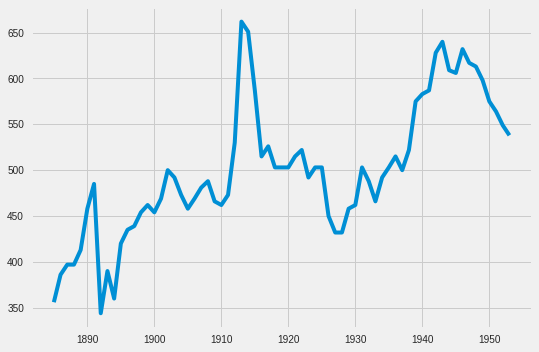

In [126]:
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('dataset.csv')
series.plot()
pyplot.show()

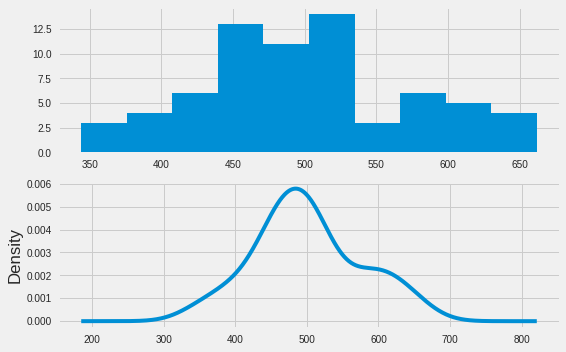

In [127]:
from pandas import Series
from matplotlib import pyplot
series = Series.from_csv('dataset.csv')
pyplot.figure(1)
pyplot.subplot(211)
series.hist()
pyplot.subplot(212)
series.plot(kind='kde')
pyplot.show()

## ARIMA Models

The ARIMA(p,d,q) model requires three parameters and is traditionally configured manually.

Analysis of the time series data assumes that we are working with a stationary time series.

The time series is likely non-stationary. We can make it stationary by first differencing the series and using a statistical test to confirm that the result is stationary.

The example below creates a stationary version of the series and saves it to file stationary.csv.

ADF Statistic: -6.126719
p-value: 0.000000
Critical Values:
	5%: -2.906
	1%: -3.534
	10%: -2.591


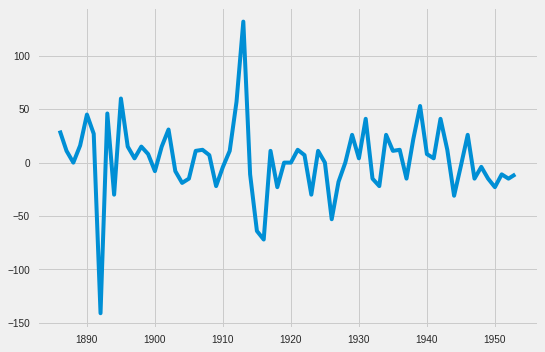

In [128]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot

# create a differe
def difference(dataset):
	diff = list()
	for i in range(1, len(dataset)):
		value = dataset[i] - dataset[i - 1]
		diff.append(value)
	return Series(diff)

series = Series.from_csv('dataset.csv')
X = series.values
X = X.astype('float32')
# difference data
stationary = difference(X)
stationary.index = series.index[1:]
# check if stationary
result = adfuller(stationary)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))
# plot differenced data
stationary.plot()
pyplot.show()
# save
stationary.to_csv('stationary.csv')

Running the example outputs the result of a statistical significance test of whether the differenced series is stationary. Specifically, the augmented Dickey-Fuller test.

The results show that the test statistic value -6.126719 is smaller than the critical value at 1% of -3.534. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).

Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.

This suggests that at least one level of differencing is required. The d parameter in our ARIMA model should at least be a value of 1.

A plot of the differenced data is also created. It suggests that this has indeed removed the increasing trend.

The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.

We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.

The example below creates ACF and PACF plots for the series.

Below are some observations from the plots.

* The ACF shows no significant lags.
* The PACF shows significant spikes at lag 1 and 2.

A good starting point for the p and q values are 2 and 0.

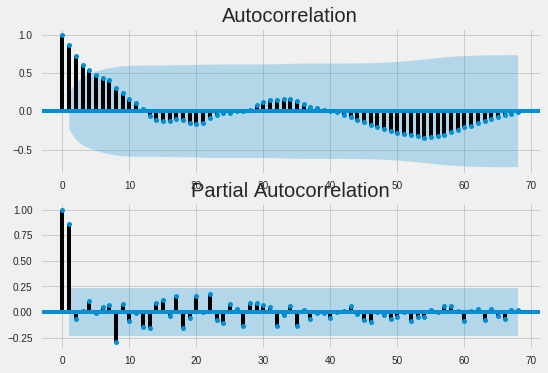

In [129]:
from pandas import Series
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot
series = Series.from_csv('dataset.csv')
pyplot.figure()
pyplot.subplot(211)
plot_acf(series, ax=pyplot.gca())
pyplot.subplot(212)
plot_pacf(series, ax=pyplot.gca())
pyplot.show()

This quick analysis suggests an ARIMA(2,1,0) on the raw data may be a good starting point.

In [130]:
from pandas import Series
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)

>Predicted=506.539, Expected=503
>Predicted=509.686, Expected=503
>Predicted=507.453, Expected=515
>Predicted=519.821, Expected=522
>Predicted=525.780, Expected=492
>Predicted=494.875, Expected=503
>Predicted=509.868, Expected=503
>Predicted=505.934, Expected=450
>Predicted=452.049, Expected=432
>Predicted=438.515, Expected=432
>Predicted=435.451, Expected=458
>Predicted=461.069, Expected=462
>Predicted=462.051, Expected=503
>Predicted=507.090, Expected=488
>Predicted=487.307, Expected=466
>Predicted=469.348, Expected=492
>Predicted=497.501, Expected=503
>Predicted=503.665, Expected=515
>Predicted=517.442, Expected=500
>Predicted=501.526, Expected=522
>Predicted=527.024, Expected=575
>Predicted=578.166, Expected=583
>Predicted=581.937, Expected=587
>Predicted=590.672, Expected=628
>Predicted=633.763, Expected=640
>Predicted=641.388, Expected=609
>Predicted=611.403, Expected=606
>Predicted=614.049, Expected=632
>Predicted=638.005, Expected=617
>Predicted=618.047, Expected=613
>Predicted

Grid Search ARIMA Hyperparameters

The ACF and PACF plots suggest that we cannot do better than a persistence model on this dataset.

To confirm this analysis, we can grid search a suite of ARIMA hyperparameters and check that no models result in better out of sample RMSE performance.

In this section, we will search values of p, d, and q for combinations (skipping those that fail to converge), and find the combination that results in the best performance. We will use a grid search to explore all combinations in a subset of integer values.

Specifically, we will search all combinations of the following parameters:

* p: 0 to 4.
* d: 0 to 2.
* q: 0 to 4.

We will also disable the automatic addition of a trend constant from the model by setting the ‘trend‘ argument to ‘nc‘ for no constant when calling fit().

The complete worked example with the grid search version of the test harness is listed below.

In [131]:
import warnings
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# evaluate an ARIMA model for a given order (p,d,q) and return RMSE
def evaluate_arima_model(X, arima_order):
	# prepare training dataset
	X = X.astype('float32')
	train_size = int(len(X) * 0.50)
	train, test = X[0:train_size], X[train_size:]
	history = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(history, order=arima_order)
		# model_fit = model.fit(disp=0)
		model_fit = model.fit(trend='nc', disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		history.append(test[t])
	# calculate out of sample error
	mse = mean_squared_error(test, predictions)
	rmse = sqrt(mse)
	return rmse

# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
	dataset = dataset.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse = evaluate_arima_model(dataset, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
					print('ARIMA%s RMSE=%.3f' % (order,mse))
				except:
					continue
	print('Best ARIMA%s RMSE=%.3f' % (best_cfg, best_score))

# load dataset
series = Series.from_csv('dataset.csv')
# evaluate parameters
p_values = range(0, 5)
d_values = range(0, 3)
q_values = range(0, 5)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 1) RMSE=282.656
ARIMA(0, 0, 4) RMSE=77.343
ARIMA(0, 1, 1) RMSE=21.907
ARIMA(0, 1, 2) RMSE=22.182
ARIMA(0, 1, 3) RMSE=24.733
ARIMA(0, 1, 4) RMSE=24.845
ARIMA(0, 2, 1) RMSE=22.381
ARIMA(0, 2, 2) RMSE=22.244
ARIMA(1, 0, 0) RMSE=21.996
ARIMA(1, 1, 0) RMSE=21.922
ARIMA(1, 2, 0) RMSE=27.464
ARIMA(1, 2, 1) RMSE=22.271
ARIMA(2, 1, 0) RMSE=21.733
ARIMA(2, 2, 0) RMSE=25.282
ARIMA(3, 1, 0) RMSE=24.270
ARIMA(3, 1, 1) RMSE=25.491
ARIMA(3, 2, 0) RMSE=25.625
ARIMA(3, 2, 1) RMSE=25.008
ARIMA(4, 0, 0) RMSE=25.374
ARIMA(4, 1, 0) RMSE=24.802
ARIMA(4, 1, 1) RMSE=25.103
ARIMA(4, 2, 0) RMSE=27.089
ARIMA(4, 2, 1) RMSE=25.933
ARIMA(4, 2, 2) RMSE=25.418
Best ARIMA(2, 1, 0) RMSE=21.733


The results show that the best configuration discovered was ARIMA(2, 1, 0) with an RMSE of 21.733, slightly lower than the manual persistence model tested earlier, but may or may not be significantly different.

## Review Residual Errors

We can check this by using summary statistics and plots to investigate the residual errors from the ARIMA(2, 1, 0) model. The example below calculates and summarizes the residual forecast errors.

               0
count  35.000000
mean    1.081624
std    22.022566
min   -52.103811
25%   -16.202284
50%    -0.459805
75%    12.085091
max    51.284339


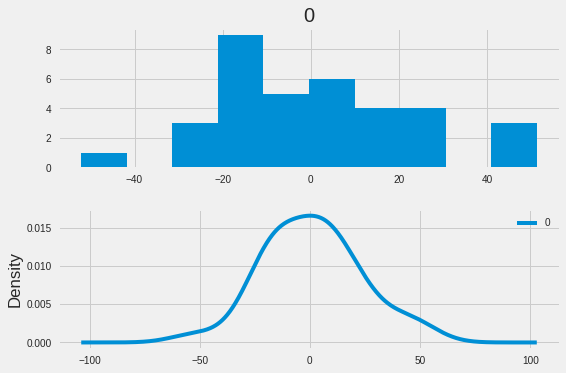

In [132]:
from pandas import Series
from pandas import DataFrame
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
from math import sqrt
from matplotlib import pyplot
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
# errors
residuals = [test[i]-predictions[i] for i in range(len(test))]
residuals = DataFrame(residuals)
print(residuals.describe())
pyplot.figure()
pyplot.subplot(211)
residuals.hist(ax=pyplot.gca())
pyplot.subplot(212)
residuals.plot(kind='kde', ax=pyplot.gca())
pyplot.show()

The graphs suggest a Gaussian-like distribution with a longer right tail, providing further evidence that perhaps a power transform might be worth exploring.

We could use this information to bias-correct predictions by adding the mean residual error of 1.081624 to each forecast made.

## Model Validation

The example below performs this bias-correction.

In [0]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import numpy

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
	return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))

ARIMA.__getnewargs__ = __getnewargs__

# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32')
# fit model
model = ARIMA(X, order=(2,1,0))
model_fit = model.fit(trend='nc', disp=0)
# bias constant, could be calculated from in-sample mean residual
bias = 1.081624
# save model
model_fit.save('model.pkl')
numpy.save('model_bias.npy', [bias])

In [134]:
from pandas import Series
from statsmodels.tsa.arima_model import ARIMAResults
import numpy
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
yhat = bias + float(model_fit.forecast()[0])
print('Predicted: %.3f' % yhat)

Predicted: 540.013


### Validate Model

>Predicted=540.013, Expected=568
>Predicted=571.589, Expected=575
>Predicted=573.289, Expected=579
>Predicted=579.561, Expected=587
>Predicted=588.063, Expected=602
>Predicted=603.022, Expected=594
>Predicted=593.178, Expected=587
>Predicted=588.558, Expected=587
>Predicted=588.797, Expected=625
>Predicted=627.941, Expected=613
RMSE: 16.532


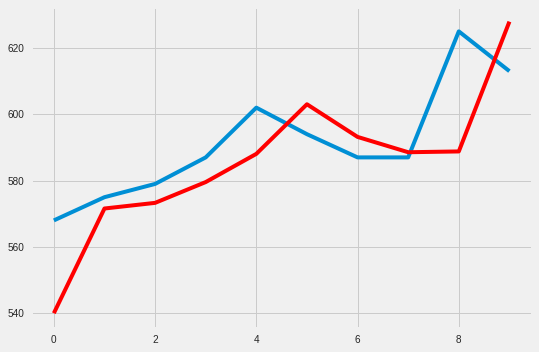

In [135]:
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from sklearn.metrics import mean_squared_error
from math import sqrt
import numpy
# load and prepare datasets
dataset = Series.from_csv('dataset.csv')
X = dataset.values.astype('float32')
history = [x for x in X]
validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32')
# load model
model_fit = ARIMAResults.load('model.pkl')
bias = numpy.load('model_bias.npy')
# make first prediction
predictions = list()
yhat = bias + float(model_fit.forecast()[0])
predictions.append(yhat)
history.append(y[0])
print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))
# rolling forecasts
for i in range(1, len(y)):
	# predict
	model = ARIMA(history, order=(2,1,0))
	model_fit = model.fit(trend='nc', disp=0)
	yhat = bias + float(model_fit.forecast()[0])
	predictions.append(yhat)
	# observation
	obs = y[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))
# report performance
mse = mean_squared_error(y, predictions)
rmse = sqrt(mse)
print('RMSE: %.3f' % rmse)
pyplot.plot(y)
pyplot.plot(predictions, color='red')
pyplot.show()

# A Guide to Time Series Forecasting with ARIMA

https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

In [0]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

We'll be working with a dataset called "Atmospheric CO2 from Continuous Air Samples at Mauna Loa Observatory, Hawaii, U.S.A.," which collected CO2 samples from March 1958 to December 2001.

In [0]:
data = sm.datasets.co2.load_pandas()
y = data.data

In [138]:
# The 'MS' string groups the data in buckets by start of the month
y = y['co2'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
1959-11-01    314.875000
1959-12-01    315.525000
1960-01-01    316.380000
1960-02-01    316.975000
1960-03-01    317.575000
1960-04-01    319.120000
1960-05-01    319.925000
1960-06-01    319.450000
1960-07-01    318.060000
1960-08-01    315.775000
                 ...    
1999-07-01    369.000000
1999-08-01    366.700000
1999-09-01    364.675000
1999-10-01    365.140000
1999-11-01    366.650000
1999-12-01    367.900000
2000-01-01    369.020000
2000-02-01    369.375000
2000-03-01    370.400000


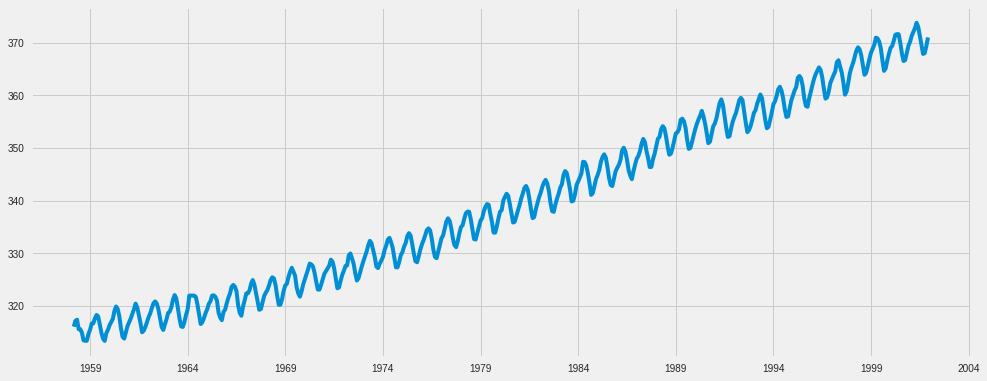

In [139]:
y.plot(figsize=(15, 6))
plt.show()

When looking to fit time series data with a seasonal ARIMA model, our first goal is to find the values of ARIMA(p,d,q)(P,D,Q)s that optimize a metric of interest. There are many guidelines and best practices to achieve this goal, yet the correct parametrization of ARIMA models can be a painstaking manual process that requires domain expertise and time. Other statistical programming languages such as R provide automated ways to solve this issue, but those have yet to be ported over to Python. In this section, we will resolve this issue by writing Python code to programmatically select the optimal parameter values for our ARIMA(p,d,q)(P,D,Q)s time series model.

We will use a "grid search" to iteratively explore different combinations of parameters. For each combination of parameters, we fit a new seasonal ARIMA model with the SARIMAX() function from the statsmodels module and assess its overall quality. Once we have explored the entire landscape of parameters, our optimal set of parameters will be the one that yields the best performance for our criteria of interest. Let's begin by generating the various combination of parameters that we wish to assess:

In [140]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


When evaluating and comparing statistical models fitted with different parameters, each can be ranked against one another based on how well it fits the data or its ability to accurately predict future data points. We will use the AIC (Akaike Information Criterion) value, which is conveniently returned with ARIMA models fitted using statsmodels. The AIC measures how well a model fits the data while taking into account the overall complexity of the model. A model that fits the data very well while using lots of features will be assigned a larger AIC score than a model that uses fewer features to achieve the same goodness-of-fit. Therefore, we are interested in finding the model that yields the lowest AIC value.

In [141]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1634.66259821
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:1398.45611969
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1119.2721964
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:1383.58386615
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1276.77847302
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:1150.06896001
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:868.566761355
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1271.68026586
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:386.798639775
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:653.908333369
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:425.787899012
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:527.862735531
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:388.397745976
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:1374.90226568
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:1139.45374536
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:589.208492539
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:349.968169885
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:623.129225561
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:395.1895107
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - A

The output of our code suggests that SARIMAX(1, 1, 1)x(1, 1, 1, 12) yields the lowest AIC value of 341.353551055. We should therefore consider this to be optimal option out of all the models we have considered.

In [142]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3185      0.092      3.448      0.001       0.137       0.500
ma.L1         -0.6259      0.077     -8.179      0.000      -0.776      -0.476
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8767      0.026    -33.782      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.633      0.000       0.089       0.106


In [0]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('1998-01-01'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

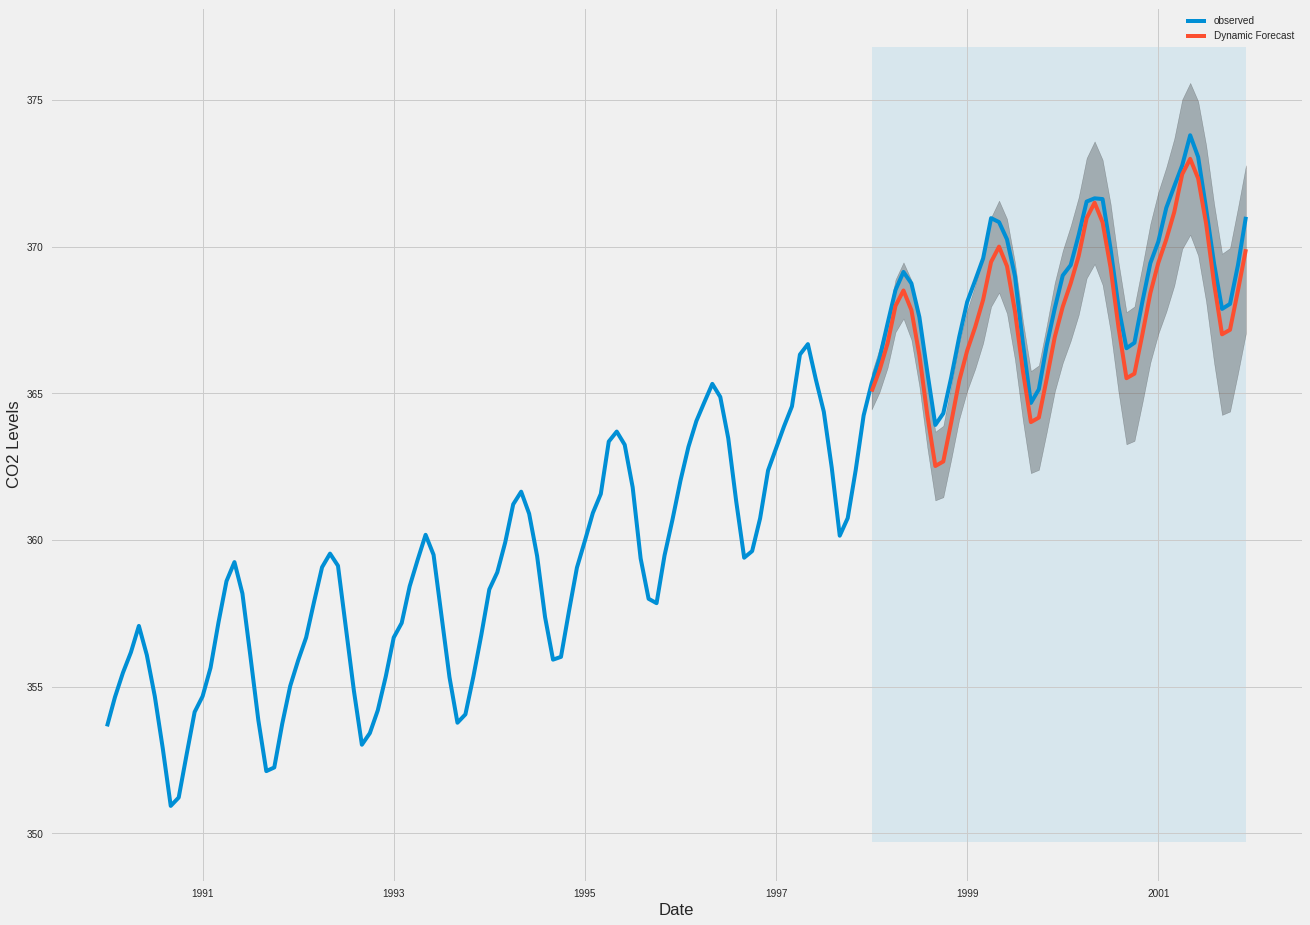

In [144]:
ax = y['1990':].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('1998-01-01'), y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO2 Levels')

plt.legend()
plt.show()

In [145]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1.01


# [Optional] LSTM

https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/

## Nonseasonal - Annual Water Usage in Baltimore

In [0]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [0]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [0]:
# load data
series = Series.from_csv('dataset.csv')
# prepare data
X = series.values
X = X.astype('float32').reshape(-1,1)

validation = Series.from_csv('validation.csv')
y = validation.values.astype('float32').reshape(-1,1)

In [0]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
Y = scaler.fit_transform(y)

train = X
test = Y

In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [0]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [193]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=0)

In [194]:
# make predictions
testPredict = model.predict(testX)
# invert predictions
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 14.40 RMSE
